In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define parameters
E_Na = 115.0  # [mV]
E_K = -12.0  # [mV]
E_L = 10.6  # [mV]

g_L = 0.3  # [mS]

dt = 0.01  # [ms]
T = 40  # [ms]

# Define time
t = np.arange(0, T, dt)
n_t = len(t)

# Initialize voltage and channel variable arrays
V = np.zeros(n_t)
n = np.zeros(n_t)
m = np.zeros(n_t)
h = np.zeros(n_t)

I_E = 0.0
V[0] = 0.0
n[0] = 0.31
m[0] = 0.05
h[0] = 0.59


# Define parameter functions
def alpha_n(V):
    return (0.1 - 0.01 * V) / (np.exp(1 - 0.1 * V) - 1)


def beta_n(V):
    return 0.125 * np.exp(-V / 80.0)


def alpha_m(V):
    return (2.5 - 0.1 * V) / (np.exp(2.5 - 0.1 * V) - 1)


def beta_m(V):
    return 4.0 * np.exp(-V / 18.0)


def alpha_h(V):
    return 0.07 * np.exp(-V / 20.0)


def beta_h(V):
    return 1 / (np.exp(3 - 0.1 * V) + 1)


def tau(alpha, beta):
    return 1.0 / (alpha + beta)


# Calculate tau and inf
def compute_tau_inf(V, alpha, beta):
    tau = 1.0 / (alpha + beta)
    inf = alpha * tau
    return tau, inf


# Update gating variable
def update_gating_variable(g, tau, inf, dt):
    return (1 - dt / tau) * g + (dt / tau) * inf


# Compute inf modulo using Boltzmann function
def compute_inf_mod(V, V_half, k):
    exp_val = np.exp(-(V - V_half) / k)
    inf = 1.0 / (1 + exp_val)
    return inf


def run_simulation(V_half_n, k_n, g_Na, g_K, I_E):
    V = np.zeros(n_t)
    n = np.zeros(n_t)
    m = np.zeros(n_t)
    h = np.zeros(n_t)
    nmh = np.zeros([n_t, 3])
    I_Na_list = np.zeros(n_t)
    inf_list = np.zeros(n_t)
    alpha_list = np.zeros(n_t)

    V[0] = 0.0
    n[0] = 0.31
    m[0] = 0.05
    h[0] = 0.59
    nmh[0] = [n[0], m[0], h[0]]
    I_Na_list[0] = g_Na * (m[0] ** 3) * h[0] * (V[0] - E_Na)
    inf_n0 = compute_inf_mod(V[0], V_half_n, k_n)
    _, inf_m0 = compute_tau_inf(V[0], alpha_m(V[0]), beta_m(V[0]))
    _, inf_h0 = compute_tau_inf(V[0], alpha_h(V[0]), beta_h(V[0]))
    inf_list[0] = inf_n0
    alpha_list[0] = alpha_n(V[0])

    for i in range(1, len(t)):
        if i == 1000:
            I_E = 10.0
        if i == 1500:
            I_E = 0.0

        inf_n = compute_inf_mod(V[i-1], V_half_n, k_n)
        tau_m, inf_m = compute_tau_inf(V[i-1], alpha_m(V[i-1]), beta_m(V[i-1]))
        tau_h, inf_h = compute_tau_inf(V[i-1], alpha_h(V[i-1]), beta_h(V[i-1]))
        tau_n = tau(alpha_n(V[i-1]), beta_n(V[i-1]))

        n[i] = update_gating_variable(n[i-1], tau_n, inf_n, dt)
        m[i] = update_gating_variable(m[i-1], tau_m, inf_m, dt)
        h[i] = update_gating_variable(h[i-1], tau_h, inf_h, dt)

        I_Na = g_Na * (m[i] ** 3) * h[i] * (V[i-1] - E_Na)
        I_K = g_K * (n[i] ** 4) * (V[i-1] - E_K)
        I_L = g_L * (V[i-1] - E_L)

        dv = I_E - (I_Na + I_K + I_L)
        V[i] = V[i-1] + dv * dt
        nmh[i] = [n[i], m[i], h[i]]
        I_Na_list[i] = I_Na
        inf_list[i] = inf_n
        alpha_list[i] = alpha_n(V[i])

    return V, nmh, I_Na_list, inf_list, alpha_list


# Generate 900 data
data_V = np.zeros((900, n_t))
data_nm = np.zeros((900, n_t, 3))
data_inf = np.zeros((900, n_t))
change_indicator = np.zeros((900, 4))
Na_current = np.zeros((900, n_t))
sixty_alpha = np.zeros((60, n_t))

for i in range(300):
    V_half_n = np.random.uniform(12.62, 15.62)
    k_n = np.random.uniform(17.52, 19.52)
    V, nmh, I_Na_list, inf_list, _ = run_simulation(V_half_n, k_n, 120.0, 36.0, 0.0)
    if i in range(280, 300):
        sixty_alpha[i-280] = _
    data_V[i] = V
    data_nm[i] = nmh
    data_inf[i] = inf_list
    Na_current[i] = I_Na_list
    change_indicator[i] = [1, 0, 0, 0]

for i in range(300, 600):
    g_Na = np.random.uniform(84.0, 156.0)
    V, nmh, I_Na_list, inf_list, _ = run_simulation(14.005, 17.534, g_Na, 36.0, 0.0)
    if i in range(580, 600):
        sixty_alpha[i-560] = _
    data_V[i] = V
    data_nm[i] = nmh
    data_inf[i] = inf_list
    Na_current[i] = I_Na_list
    change_indicator[i] = [0, 1, 0, g_Na]

for i in range(600, 900):
    g_K = np.random.uniform(30, 42)
    V, nmh, I_Na_list, inf_list, _ = run_simulation(14.005, 17.534, 120.0, g_K, 0.0)
    if i in range(880, 900):
        sixty_alpha[i-840] = _
    data_V[i] = V
    data_nm[i] = nmh
    data_inf[i] = inf_list
    Na_current[i] = I_Na_list
    change_indicator[i] = [0, 0, 1, g_K]
change_indicator_expanded = np.repeat(change_indicator[:, np.newaxis, :], n_t, axis=1)
data_combined = np.concatenate((data_nm, change_indicator_expanded), axis=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


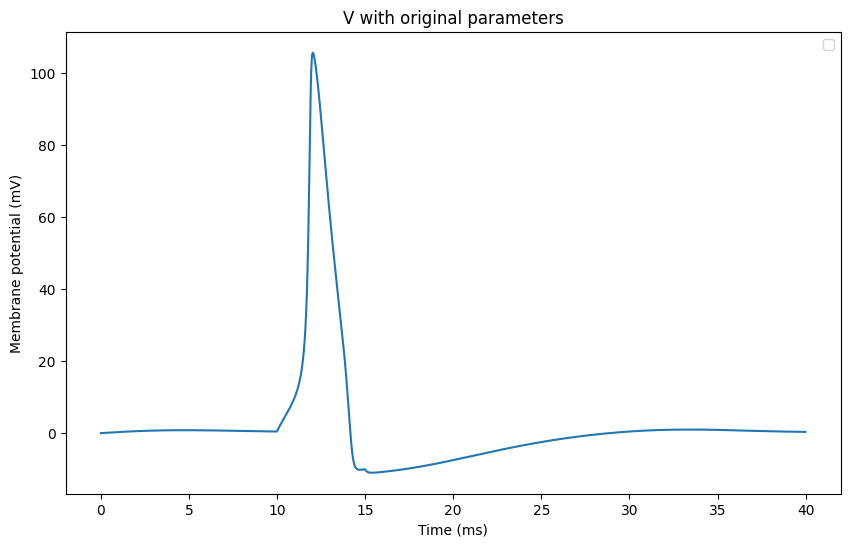

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


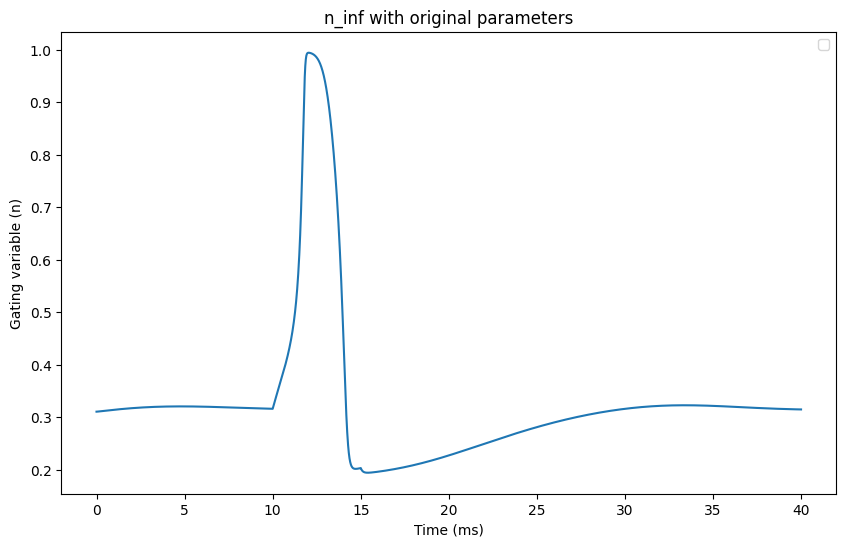

In [3]:
# Plot using original parameters
V, nmh, I_Na_list, inf_list, _ = run_simulation(14.005, 17.534, 120.0, 36.0, 0.0)
plt.figure(figsize=(10, 6))
plt.plot(t, V)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('V with original parameters')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, inf_list[:])
plt.xlabel('Time (ms)')
plt.ylabel('Gating variable (n)')
plt.title('n_inf with original parameters')
plt.show()

In [5]:
# Save directories
np.save('deeponet_data/V_data.npy', data_V)  # (900, 4000)
np.save('deeponet_data/nmh_data.npy', data_combined)  # （900, 4000, 7)
np.save('deeponet_data/inf_data.npy', data_inf)  # (900, 4000, 3)
np.save('deeponet_data/60alpha_data.npy', sixty_alpha)  # (60, 4000, 3)